### Importing Libraries and Read In Dataset


In [113]:
#Import Libraries
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data viz
import seaborn as sns #data viz
from sklearn.impute import SimpleImputer #imputes missing vals
from datetime import datetime 
from sklearn.preprocessing import StandardScaler, OneHotEncoder #preprocessing
from sklearn.compose import ColumnTransformer #preprocessing
from sklearn.decomposition import PCA #dimensionality reduction
from sklearn.cluster import DBSCAN #clustering
from imblearn.over_sampling import SMOTE #balance classes

In [114]:
#Read In Dataset
pd.set_option('display.max_columns', None)
customer_data = pd.read_csv('marketing_campaign.csv',
                           delimiter='\t', index_col='ID')
customer_data.head()

Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
ID                                                                        
5524        1957  Graduation         Single  58138.0        0         0   
2174        1954  Graduation         Single  46344.0        1         1   
4141        1965  Graduation       Together  71613.0        0         0   
6182        1984  Graduation       Together  26646.0        1         0   
5324        1981         PhD        Married  58293.0        1         0   

     Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
ID                                                                
5524  04-09-2012       58       635         88              546   
2174  08-03-2014       38        11          1                6   
4141  21-08-2013       26       426         49              127   
6182  10-02-2014       26        11          4               20   
5324  19-01-2014       94       173         43              118   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
ID                                                                         
5524              172                88            88                  3   
2174                2                 1             6                  2   
4141              111                21            42                  1   
6182               10                 3             5                  2   
5324               46                27            15                  5   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
ID                                                              
5524                8                   10                  4   
2174                1                    1                  2   
4141                8                    2                 10   
6182                2                    0                  4   
5324                5                    3                  6   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
ID                                                                  
5524                  7             0             0             0   
2174                  5             0             0             0   
4141                  4             0             0             0   
6182                  6             0             0             0   
5324                  5             0             0             0   

      AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  Response  
ID                                                                              
5524             0             0         0              3         11         1  
2174             0             0         0              3         11         0  
4141             0             0         0              3         11         0  
6182             0             0         0              3         11         0  
5324             0             0         0              3         11         0

### Feature Engineering

In [115]:
#Feature Engineering

#Create 'Age' feature from customer's birth year
customer_data['Age'] = customer_data.Year_Birth.apply(lambda x: 2021 - int(x))

#Create 'Days_Since_Customer' feature from time the customer enrolled
customer_data['Dt_Customer'] = pd.to_datetime(customer_data.Dt_Customer)
now = datetime.now()
customer_data['Days_Since_Customer'] = customer_data.Dt_Customer.apply(lambda x: (now - x).total_seconds()/ (60 * 60 * 24))

#Create 'Fam_Size' feature from the marriage status, number of kids/teens
marital_map = {'Absurd': 1, 'Alone': 1, 'YOLO': 1, 'Single': 1,
              'Married': 2, 'Together': 2, 'Widow': 1, 'Divorced': 1}
customer_data['Marital_Status'] = customer_data.Marital_Status.map(marital_map) #Maps all singles as 1, couples as 2
customer_data['Num_Kids'] = customer_data.Kidhome.values + customer_data.Teenhome.values
customer_data['Fam_Size'] = customer_data.Marital_Status.values + customer_data.Num_Kids.values

#Create 'Num_Accepted' feature from the sum of previous marketting campaigns that were accepted by the customer
customer_data['Num_Accepted'] = customer_data.AcceptedCmp1.values + customer_data.AcceptedCmp2.values + \
                                customer_data.AcceptedCmp3.values + customer_data.AcceptedCmp4.values + \
                                customer_data.AcceptedCmp5.values

#Create 'MntTotal' for total amount spent on all items
customer_data['MntTotal'] = customer_data['MntWines'].values + customer_data['MntFruits'].values + \
                            customer_data['MntMeatProducts'].values + customer_data['MntFishProducts'].values + \
                            customer_data['MntWines'].values + customer_data['MntSweetProducts'].values + \
                            customer_data['MntGoldProds'].values

#Drops the unnecessary features from the original dataset
customer_data.drop(['Dt_Customer', 'Year_Birth', 'AcceptedCmp1', 'AcceptedCmp2',
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Kidhome', 'Teenhome',
                   'Z_CostContact', 'Z_Revenue', 'Num_Kids', 'Marital_Status'],
                   axis=1, inplace=True)
customer_data.head() 

C:\Users\M S I\AppData\Local\Temp\ipykernel_30012\4012006684.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  customer_data['Dt_Customer'] = pd.to_datetime(customer_data.Dt_Customer)


Education   Income  Recency  MntWines  MntFruits  MntMeatProducts  \
ID                                                                         
5524  Graduation  58138.0       58       635         88              546   
2174  Graduation  46344.0       38        11          1                6   
4141  Graduation  71613.0       26       426         49              127   
6182  Graduation  26646.0       26        11          4               20   
5324         PhD  58293.0       94       173         43              118   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
ID                                                                         
5524              172                88            88                  3   
2174                2                 1             6                  2   
4141              111                21            42                  1   
6182               10                 3             5                  2   
5324               46                27            15                  5   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
ID                                                              
5524                8                   10                  4   
2174                1                    1                  2   
4141                8                    2                 10   
6182                2                    0                  4   
5324                5                    3                  6   

      NumWebVisitsMonth  Complain  Response  Age  Days_Since_Customer  \
ID                                                                      
5524                  7         0         1   64           4405.97373   
2174                  5         0         0   67           3559.97373   
4141                  4         0         0   56           3906.97373   
6182                  6         0         0   37           3499.97373   
5324                  5         0         0   40           3755.97373   

      Fam_Size  Num_Accepted  MntTotal  
ID                                      
5524         1             0      2252  
2174         3             0        38  
4141         2             0      1202  
6182         3             0        64  
5324         3             0       595

### Handle Missing Values

In [116]:
#Prints the size of the dataset
print('Dataset Shape:', customer_data.shape)
print('-------------------------------')
#Check if any columns contain null
print('Total Nulls Per Column:')
print(customer_data.isnull().sum())

Dataset Shape: (2240, 21)
-------------------------------
Total Nulls Per Column:
Education               0
Income                 24
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Complain                0
Response                0
Age                     0
Days_Since_Customer     0
Fam_Size                0
Num_Accepted            0
MntTotal                0
dtype: int64


The 'Income' column contains 24 missing values. Since this only accounts for 1% of the total dataset, imputing the mean will not have great consequences.


In [117]:
#Imputes the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(customer_data.Income.values.reshape(-1,1))
customer_data['Income'] = imputer.transform(customer_data.Income.values.reshape(-1,1))

### Visualizing the Data

In [118]:
#Calculate percent of responses
pos_resp = customer_data.Response.sum()
total = customer_data.shape[0]
percent = round((pos_resp / total)*100, 2)

print(pos_resp, 'customers responded to the marketing campaign out of a total of', total, 'cutomers.')
print('Percent Responded: ' +  str(percent) + '%')

334 customers responded to the marketing campaign out of a total of 2240 cutomers.
Percent Responded: 14.91%


In [119]:
#View feature correlations with the 'Response' column
#Note: 'Response' will be the target for predictive modeling
response_corr_abs = np.abs(customer_data.corr()['Response']).sort_values(ascending=False)[1:]
response_corr = customer_data.corr()['Response'].sort_values(ascending=False)[1:]
print("Correlation Coefficients for 'Response'")
print('--------------------------------------------------------')
print(response_corr)

Correlation Coefficients for 'Response'
--------------------------------------------------------
Num_Accepted           0.426035
MntTotal               0.265518
MntWines               0.247254
MntMeatProducts        0.236335
NumCatalogPurchases    0.220810
Days_Since_Customer    0.174061
NumWebPurchases        0.148730
MntGoldProds           0.139850
Income                 0.132756
MntFruits              0.125289
MntSweetProducts       0.117372
MntFishProducts        0.111331
NumStorePurchases      0.039363
NumDealsPurchases      0.002238
Complain              -0.001707
NumWebVisitsMonth     -0.003987
Age                   -0.021325
Recency               -0.198437
Fam_Size              -0.219440
Name: Response, dtype: float64


C:\Users\M S I\AppData\Local\Temp\ipykernel_30012\73443459.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  response_corr_abs = np.abs(customer_data.corr()['Response']).sort_values(ascending=False)[1:]
C:\Users\M S I\AppData\Local\Temp\ipykernel_30012\73443459.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  response_corr = customer_data.corr()['Response'].sort_values(ascending=False)[1:]


In [120]:
#Creates function to display kde graphs
def display_kdeplot(df, col1, col2):
    plt.figure(figsize=(8,8))
    sns.kdeplot(data=df, x=col1, hue=col2, multiple="stack")
    plt.title(col1 + ' correlation with ' + col2)
    plt.legend(['Response', 'No Response'])
    plt.show()
    print(df[col1].describe())

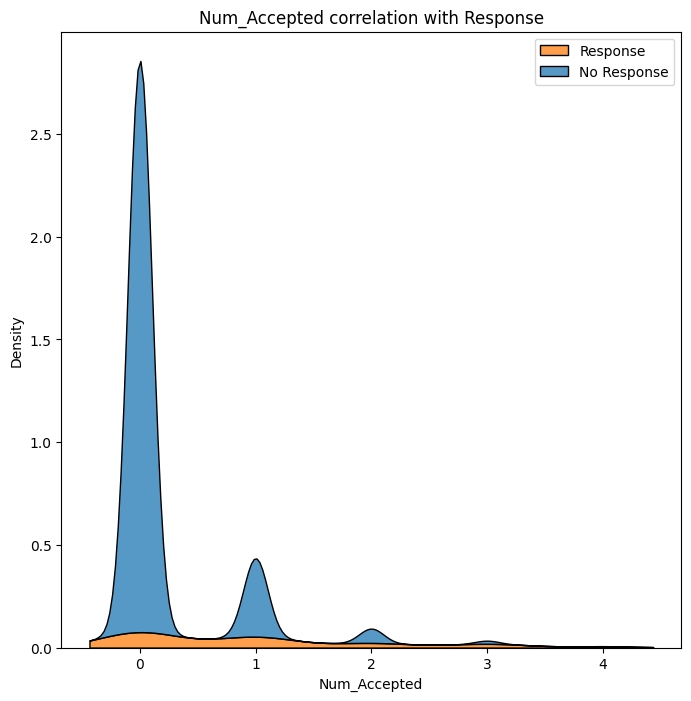

count    2240.000000
mean        0.297768
std         0.678381
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Num_Accepted, dtype: float64
Correlation %: 42.6
------------------------------------------------------------------------


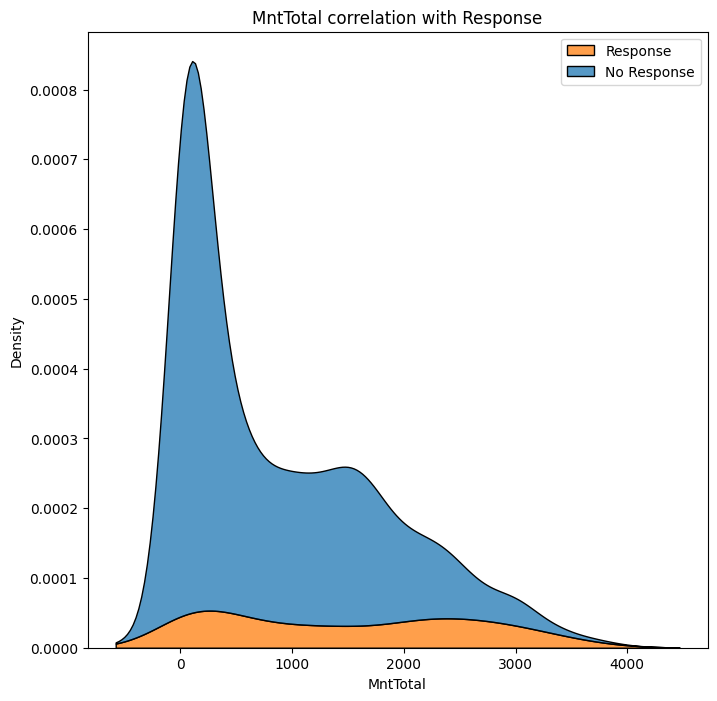

count    2240.000000
mean      909.733929
std       915.194547
min         7.000000
25%        90.750000
50%       579.500000
75%      1546.500000
max      3880.000000
Name: MntTotal, dtype: float64
Correlation %: 26.55
------------------------------------------------------------------------


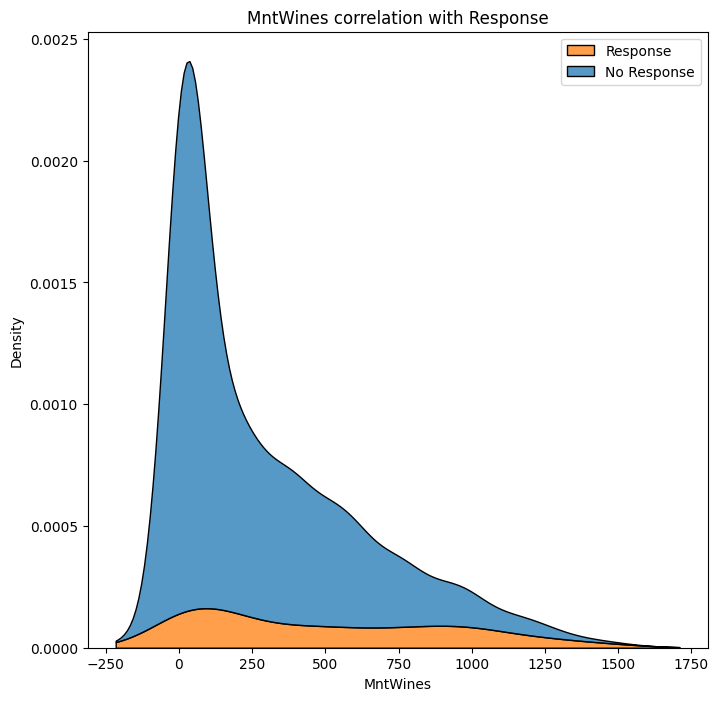

count    2240.000000
mean      303.935714
std       336.597393
min         0.000000
25%        23.750000
50%       173.500000
75%       504.250000
max      1493.000000
Name: MntWines, dtype: float64
Correlation %: 24.73
------------------------------------------------------------------------


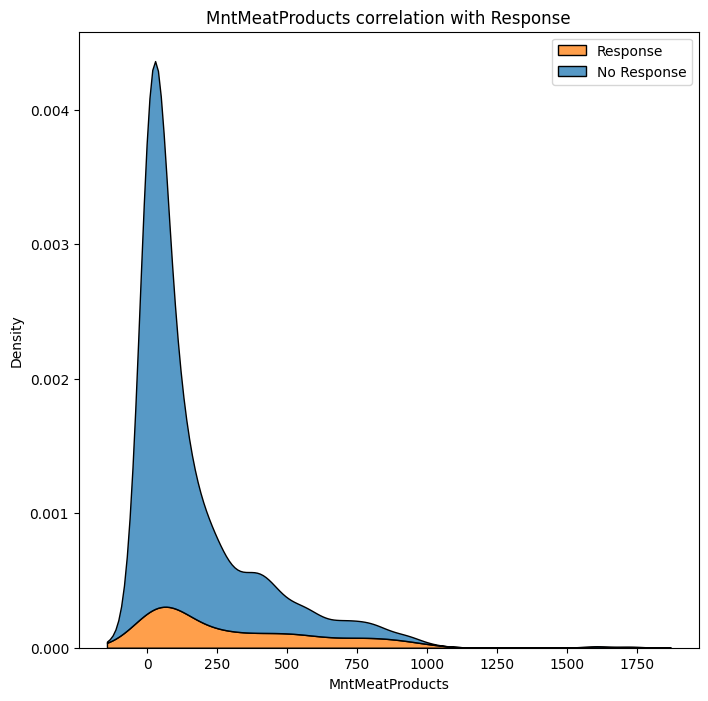

count    2240.000000
mean      166.950000
std       225.715373
min         0.000000
25%        16.000000
50%        67.000000
75%       232.000000
max      1725.000000
Name: MntMeatProducts, dtype: float64
Correlation %: 23.63
------------------------------------------------------------------------


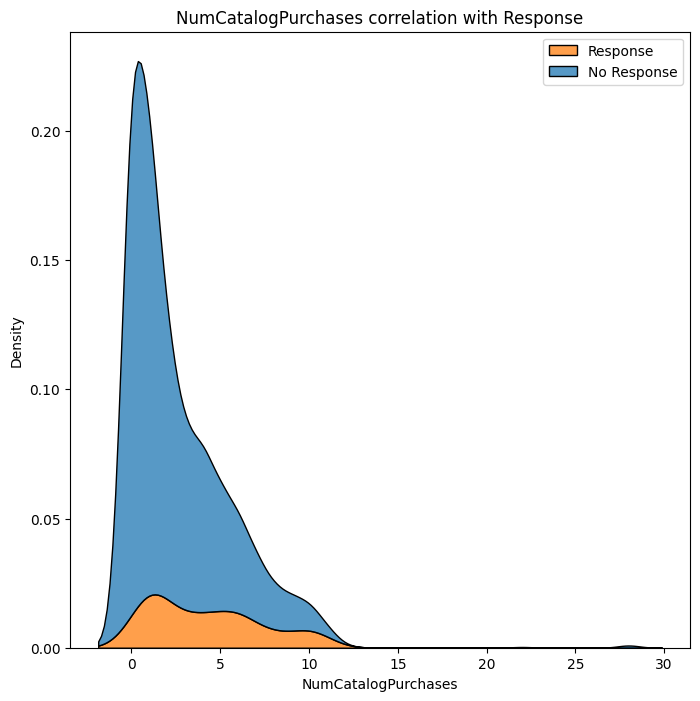

count    2240.000000
mean        2.662054
std         2.923101
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        28.000000
Name: NumCatalogPurchases, dtype: float64
Correlation %: 22.08
------------------------------------------------------------------------


In [121]:
for i in range(5):
    feature_name = response_corr_abs.index[i]
    display_kdeplot(customer_data, feature_name, 'Response')
    print('Correlation %:', round(response_corr[feature_name] * 100, 2))
    print('------------------------------------------------------------------------')

C:\Users\M S I\AppData\Local\Temp\ipykernel_30012\3401224480.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(customer_data.corr(), annot=True, cmap=cmap, center=0)


<AxesSubplot: >

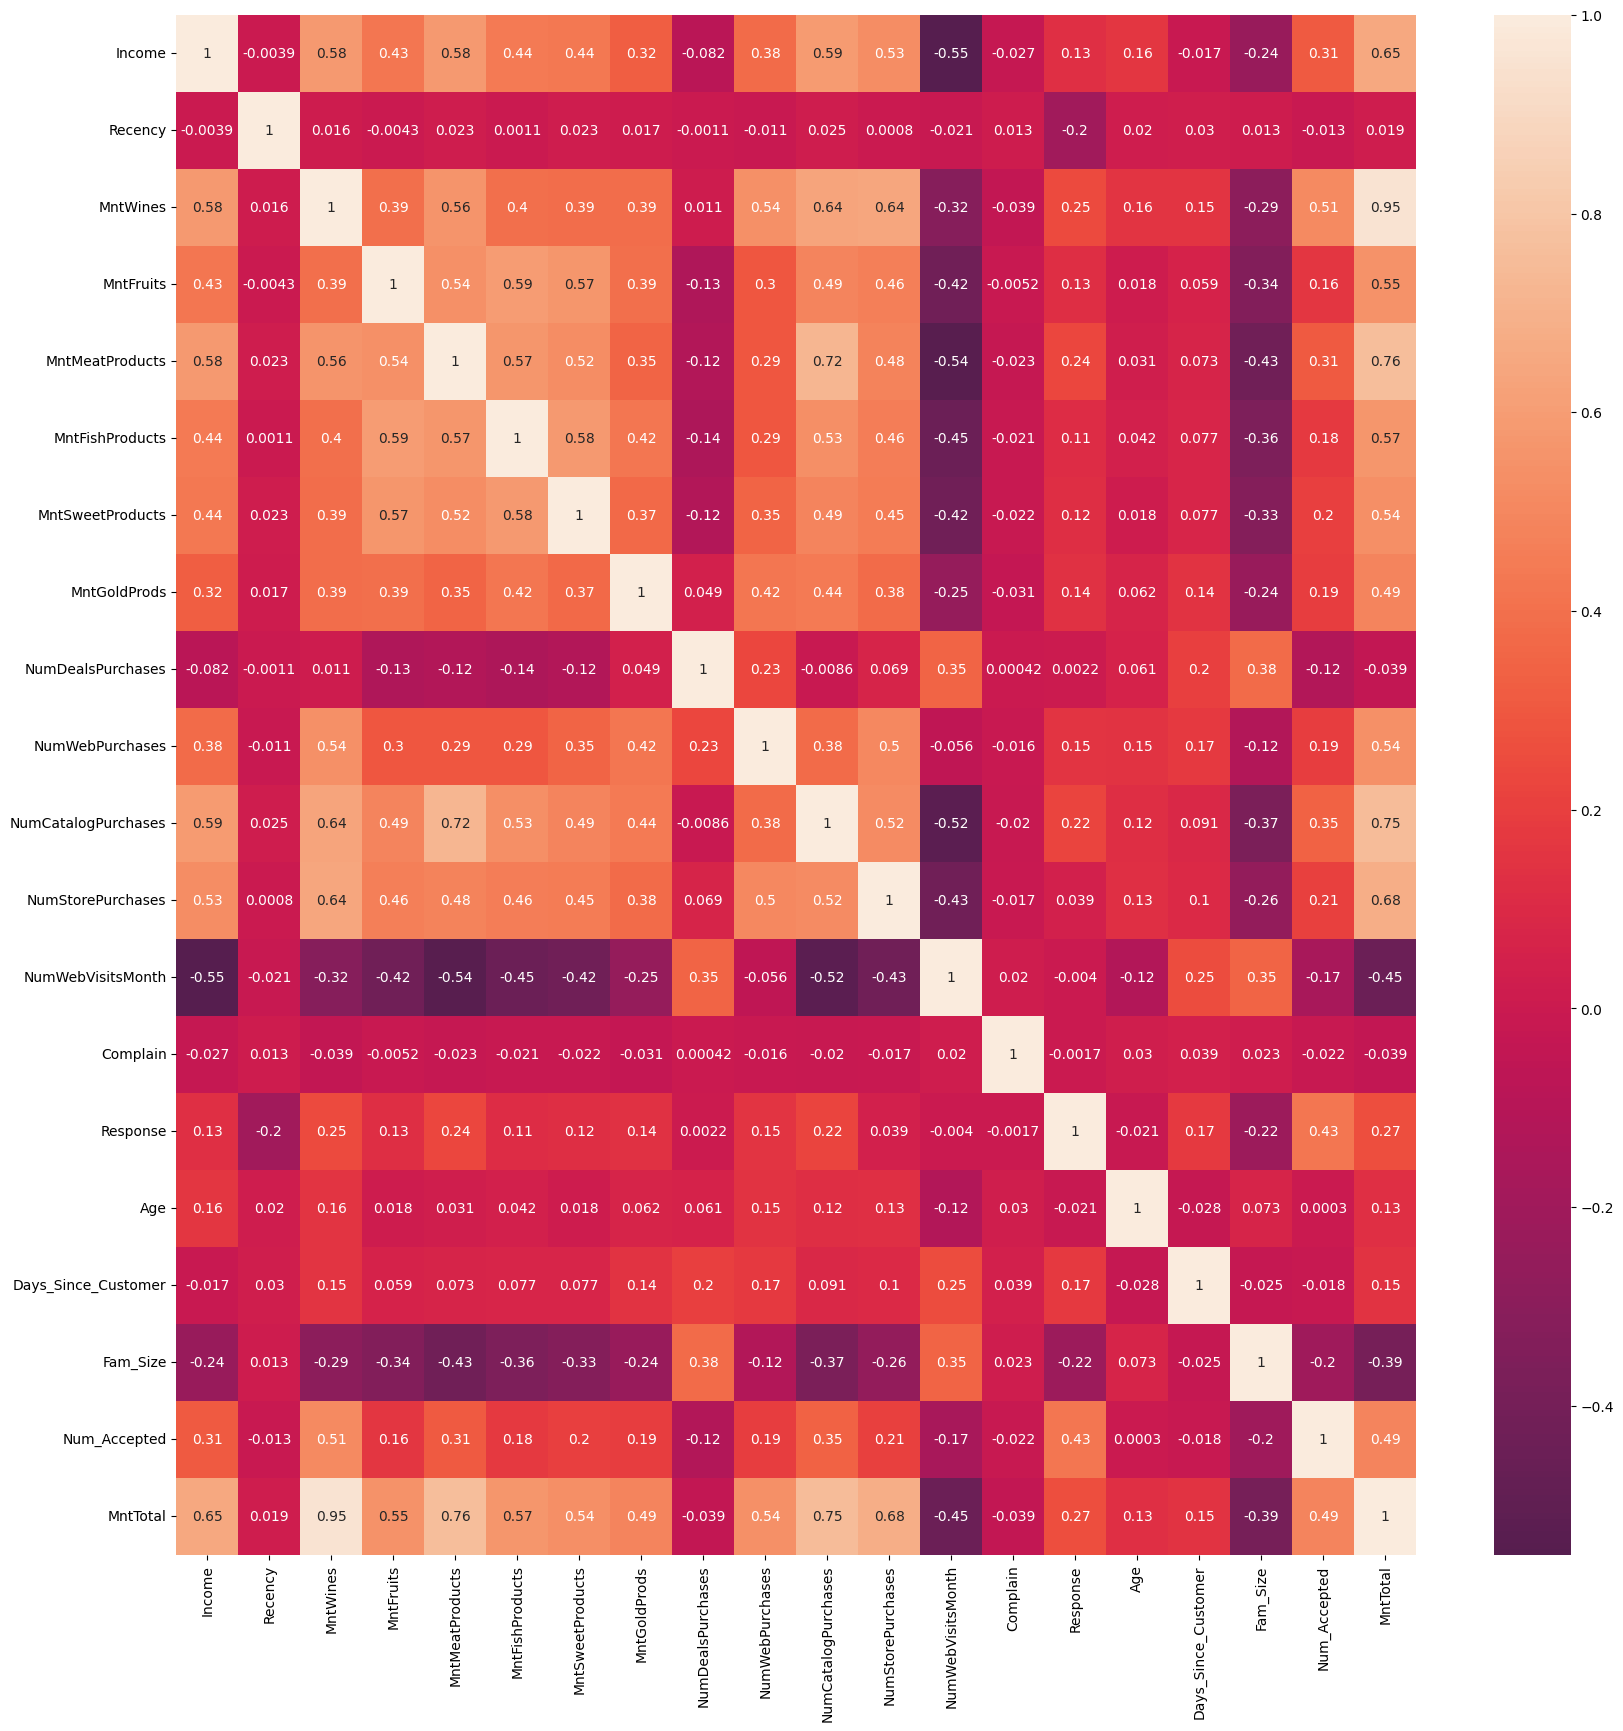

In [122]:
#plots the correlation matrix
plt.figure(figsize=(20,20))
cmap = sns.color_palette("rocket", as_cmap=True)
sns.heatmap(customer_data.corr(), annot=True, cmap=cmap, center=0)

Plot a very interesting correlated features.


In [123]:
#create function for plotting scatter plot
def display_scatterplot(df, col1, col2):
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=df, x=col1, y=col2, hue='Response')
    plt.title(col1 + ' correlation with ' + col2)
    plt.legend(['Response', 'No Response'])
    plt.show()

C:\Users\M S I\AppData\Local\Temp\ipykernel_30012\3154210119.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mx = customer_data.corr()


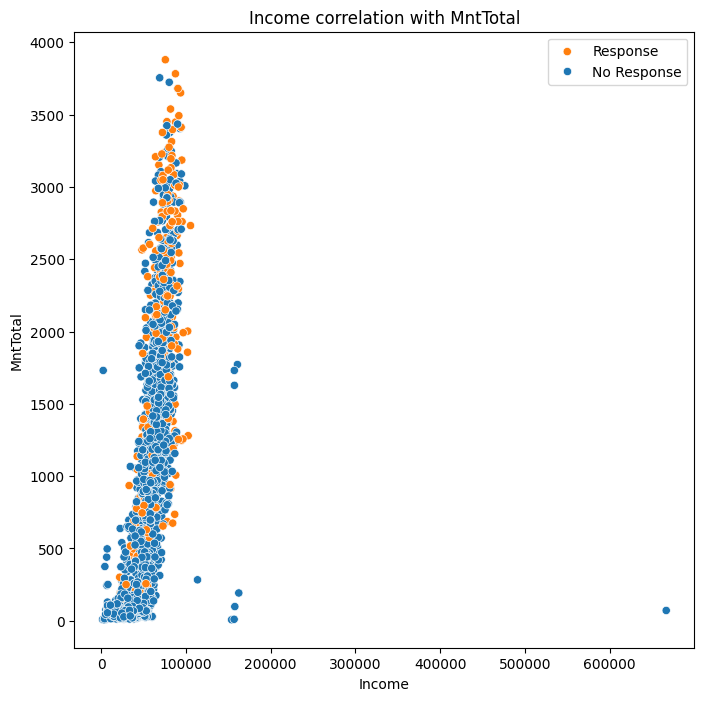

Correlation Coefficient %: 0.65
-----------------------------------------------------------


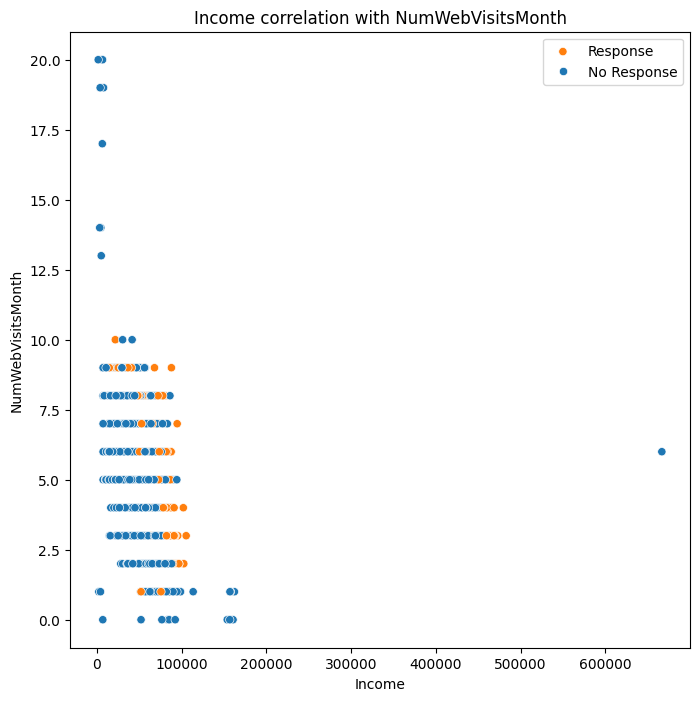

Correlation Coefficient %: -0.55
-----------------------------------------------------------


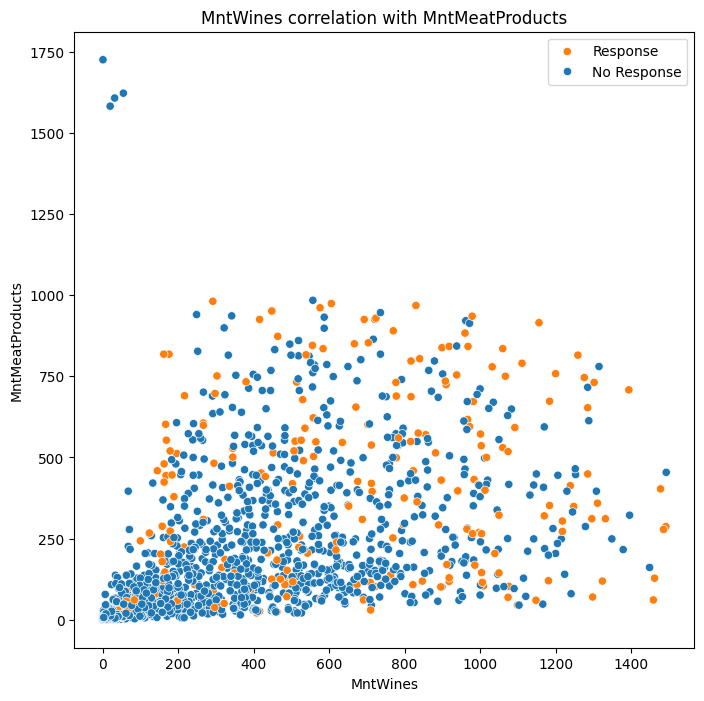

Correlation Coefficient %: 0.56
-----------------------------------------------------------


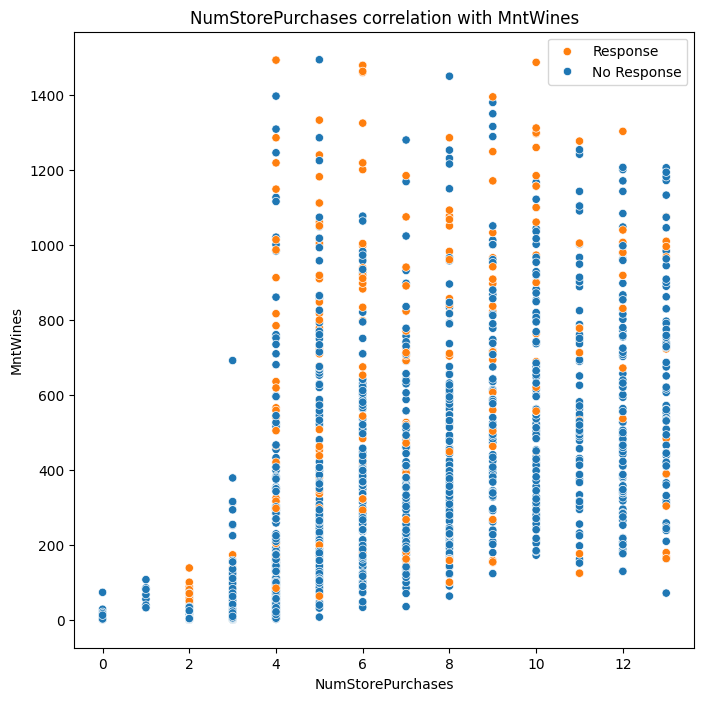

Correlation Coefficient %: 0.64
-----------------------------------------------------------


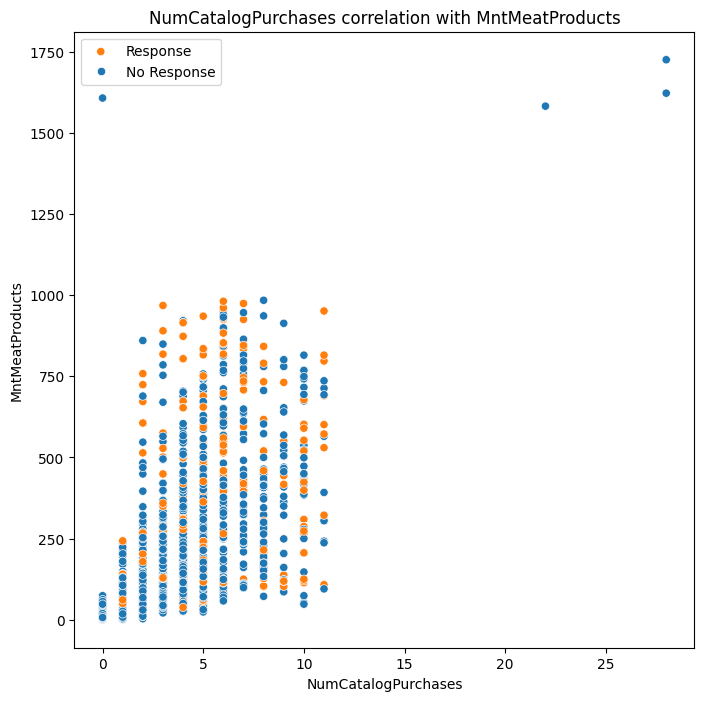

Correlation Coefficient %: 0.72
-----------------------------------------------------------


In [124]:
#Plots 5 features that have a med-high correlation selected from the above correlation matrix
corr_features = [['Income', 'MntTotal'], ['Income', 'NumWebVisitsMonth'], ['MntWines', 'MntMeatProducts'],
['NumStorePurchases', 'MntWines'], ['NumCatalogPurchases', 'MntMeatProducts']]
corr_mx = customer_data.corr()

for corr in corr_features:
    display_scatterplot(customer_data, corr[0], corr[1])
    print('Correlation Coefficient %:', round((corr_mx.loc[corr[0], corr[1]]), 2))
    print('-----------------------------------------------------------')

Conclusions On Objective 1
* Positive response to previous marketing campaigns was the most correlated with a response to the most recent ad campaign. This shows that possibly the customers are very happy with the marketing campaigns and decide to respond to the next campaign. Or this could be showing a certain group of customers that are more influenced by the campaigns.
* Total amount spent on products, especially wines and meats, are very highly correlated with whether the customer responded to the marketing campaign. However, amount spent on gold, fish, sweets and fish were not as correlated. This could be due to the nature of the most recent marketing campaign - perhaps the store was trying to sell meat and wine in the most recent campaign?
* Catalog purchases correlate with response to the current marketing campaign where as in store, online, and deal purchases have very little to no correlation. This may be due to the medium that the marketing campaign was using - maybe it was not displayed in store/online but was in all the catalogs? Another possibility is that those customers who perform catalog purchases are more influenced by the campaigns
* Customers with smaller family size responded better to the marketing campaign. Maybe the customers without family had more money to spend on the products in the campaign or the products in the campaign were for signle customers (like alcohol and party supplies). Without further inforamation on the details on the campaign it is hard to say.
* Customers who recently purchased something are likely to respond to the marketing campaign. This is pretty clear - more recent purchases = probable pattern of shopping at the store
* Income and Total Amount Spent are very correlated. Customers who earn more spend more.
* Finally, of note is Age and Complaining had virtually 0 correlation with response. This shows that the campaign did a good job of catering to all age groups and that customers who complained in the past continued bussiness at the store

### Dimensionality Reduction

The data will need some preprocessing before the dimensionality is reduced. 'Education' needs to be encoded and the other columns need to be scaled. Also, the target column 'Repsonse' needs to be removed from the dataset.

In [125]:
#Remove the 'Response' column because it is the target of future predictive model
X, y = customer_data.drop('Response', axis=1).values, customer_data['Response'].values

#Creates a column transformer that sends 'Education' to be encoded and rest scaled
ct = ColumnTransformer([
    ('catagoric', OneHotEncoder(), [0]),
    ('numeric', StandardScaler(), list(range(1, len(X.T))))
])

#Sends the data through the column transformer
X_transformed = ct.fit_transform(X)
print('Preprocessed Data:')
print(X_transformed[0])

Preprocessed Data:
[ 0.          0.          1.          0.          0.          0.23532677
  0.30703926  0.98378127  1.55157698  1.67970233  2.46214705  1.4765001
  0.84320691  0.34941394  1.40930394  2.51089024 -0.55078479  0.69390374
 -0.09728167  0.98534473  1.97674456 -1.75911463 -0.43903713  1.4669731 ]


In [126]:
#Create instance of Principal Component Analysis in order to reduce dimensionality while maintaining variance
#n_components=3 will be chosen in order to visualize the data better
pca = PCA(n_components=3)

#fit to dataset
pca.fit(X_transformed)

#create dimentionality reduced dataset
X_reduced = pca.transform(X_transformed)

print('Dimentionality Reduced Data:')
print(X_reduced[0])

Dimentionality Reduced Data:
[ 4.1962928   1.01624277 -2.28819346]


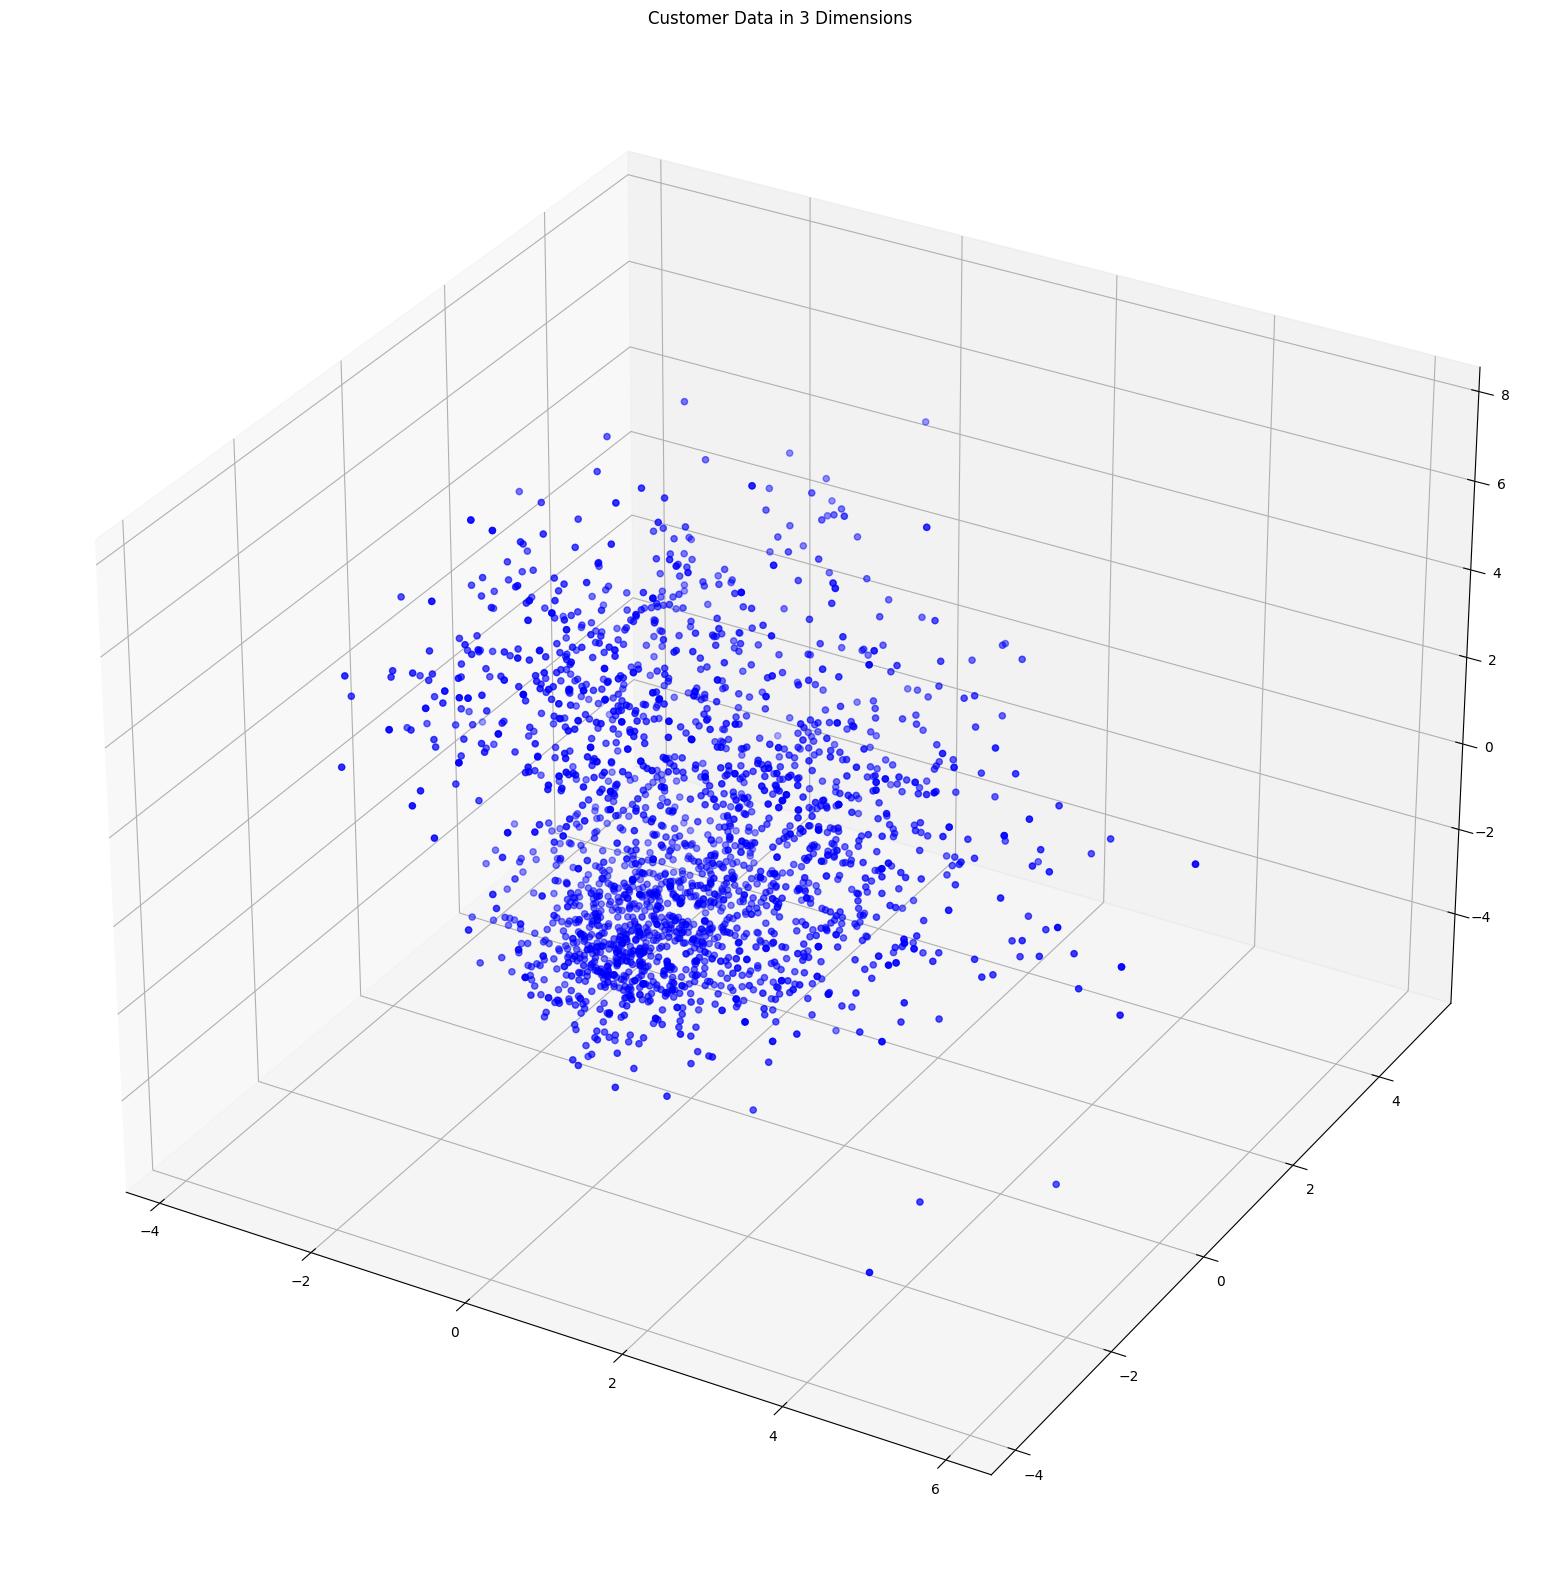

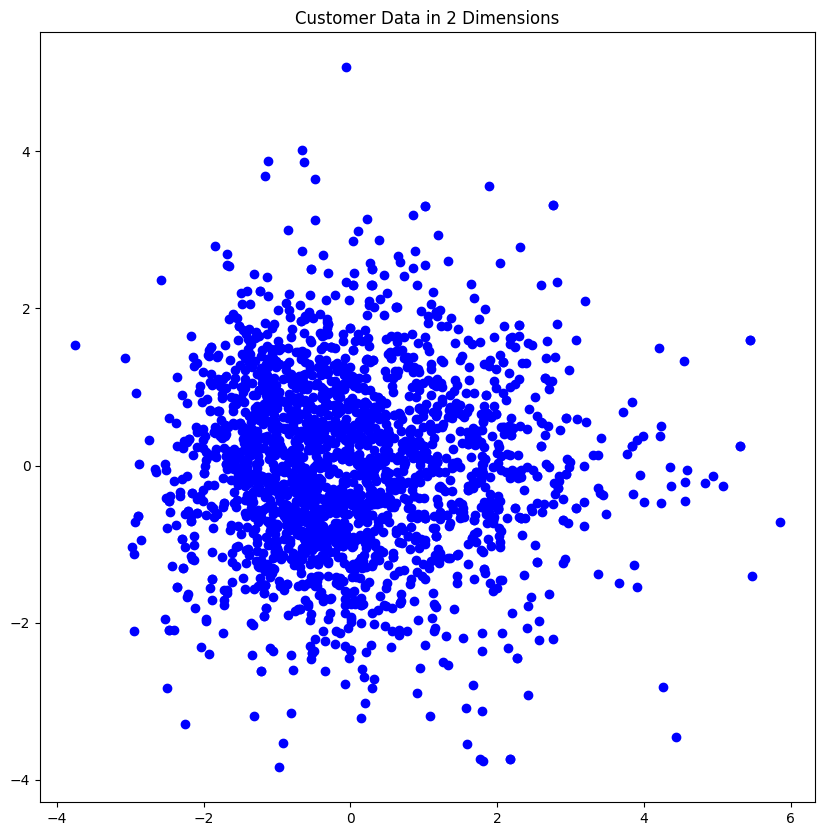

In [127]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], c="blue")
ax.set_title("Customer Data in 3 Dimensions")
plt.show()

#plot the 2d dataset
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced.T[1], X_reduced.T[2], c="blue")
plt.title('Customer Data in 2 Dimensions')
plt.xlabel('')
plt.ylabel('')
plt.show()


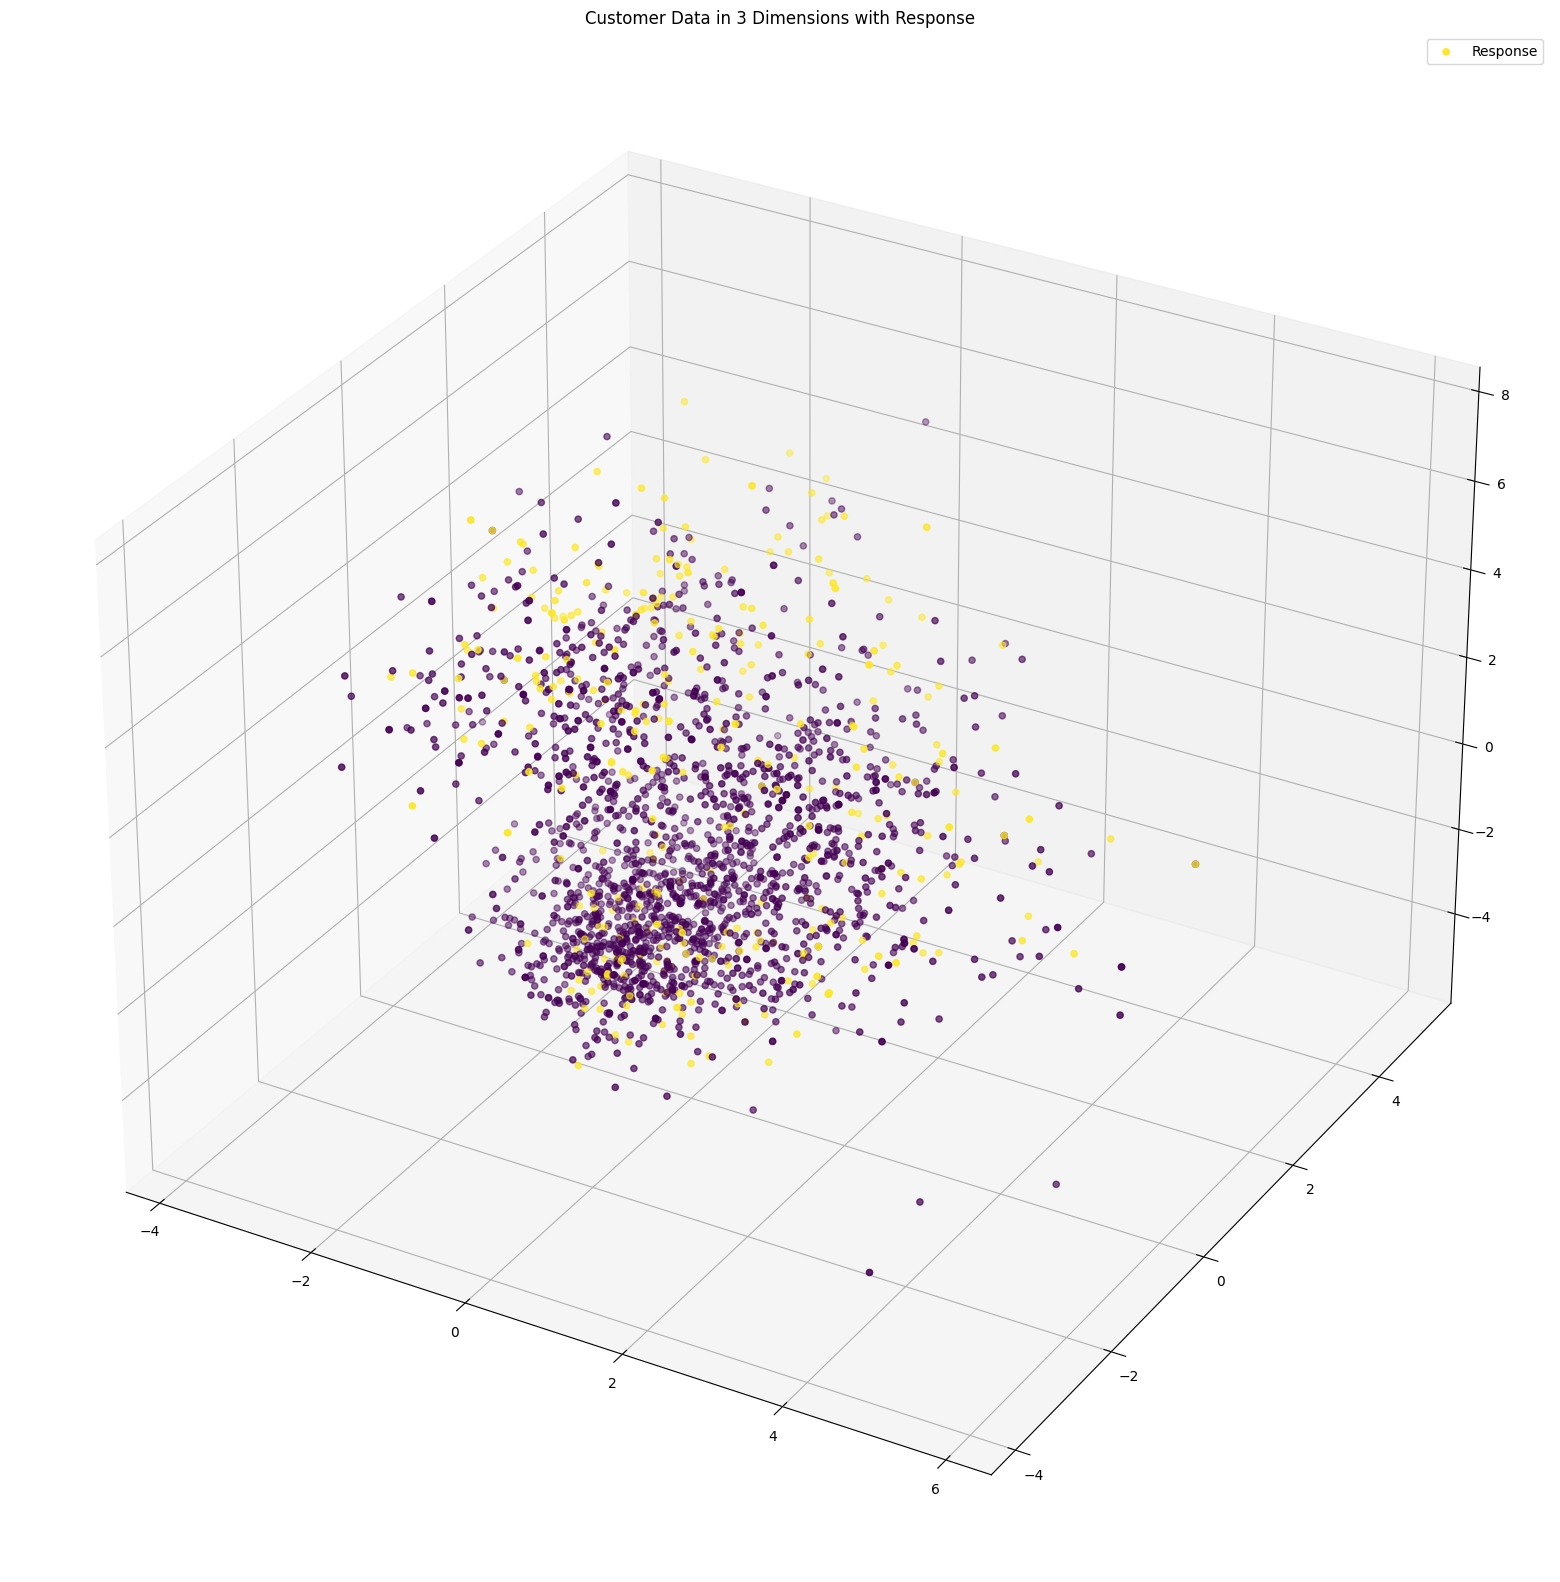

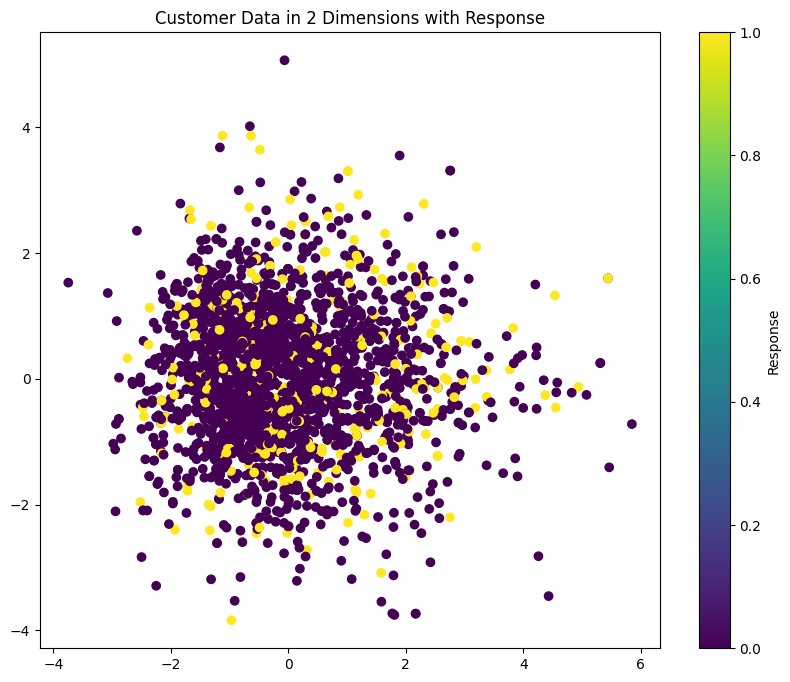

In [128]:
# plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], c=y)
ax.set_title("Customer Data in 3 Dimensions with Response")
ax.legend(['Response'])
plt.show()

#plot the 2d dataset
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced.T[1], X_reduced.T[2], c=y, cmap='viridis')
plt.title("Customer Data in 2 Dimensions with Response")
plt.xlabel("")
plt.ylabel("")
plt.colorbar(label='Response')
plt.show()


In [129]:
#Create an instance of DBSCAN to create non spherical clusters based on data density
db = DBSCAN(eps=0.726, min_samples=26)

#fit to the dimentionality reduced dataset
db.fit(X_reduced)

#identify the clusters
clusters = db.labels_

#display metrics/sample
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Cluster Predictions')
print('-------------------------------')
print("Number of clusters: %d" % n_clusters_)
print("Number of noise points: %d" % n_noise_)
print('Number of points per cluster:')
for i in range(n_clusters_):
    print('Cluster', i, ':', len(clusters[clusters==i]))

Cluster Predictions
-------------------------------
Number of clusters: 3
Number of noise points: 751
Number of points per cluster:
Cluster 0 : 1291
Cluster 1 : 29
Cluster 2 : 169


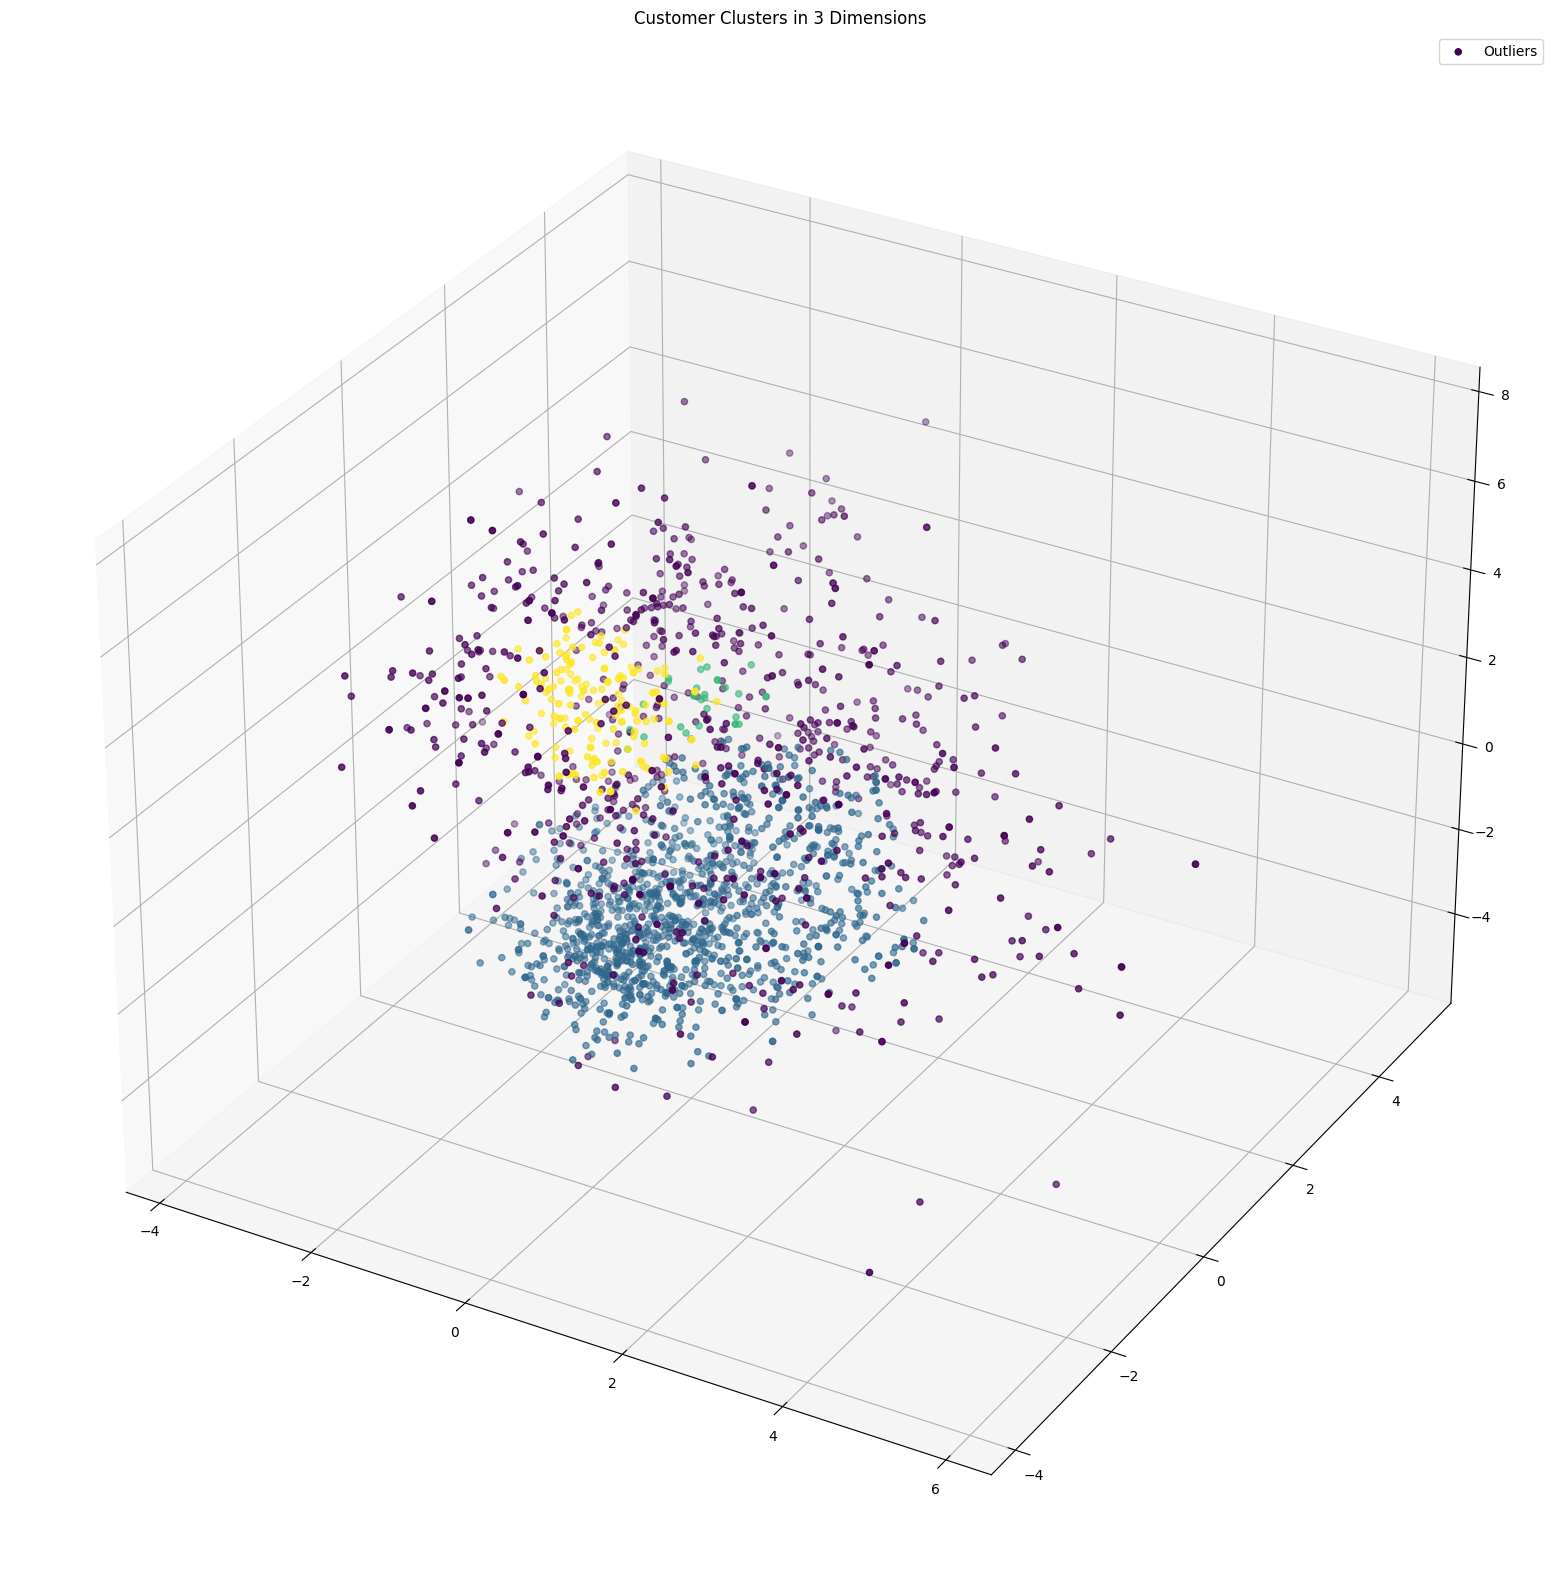

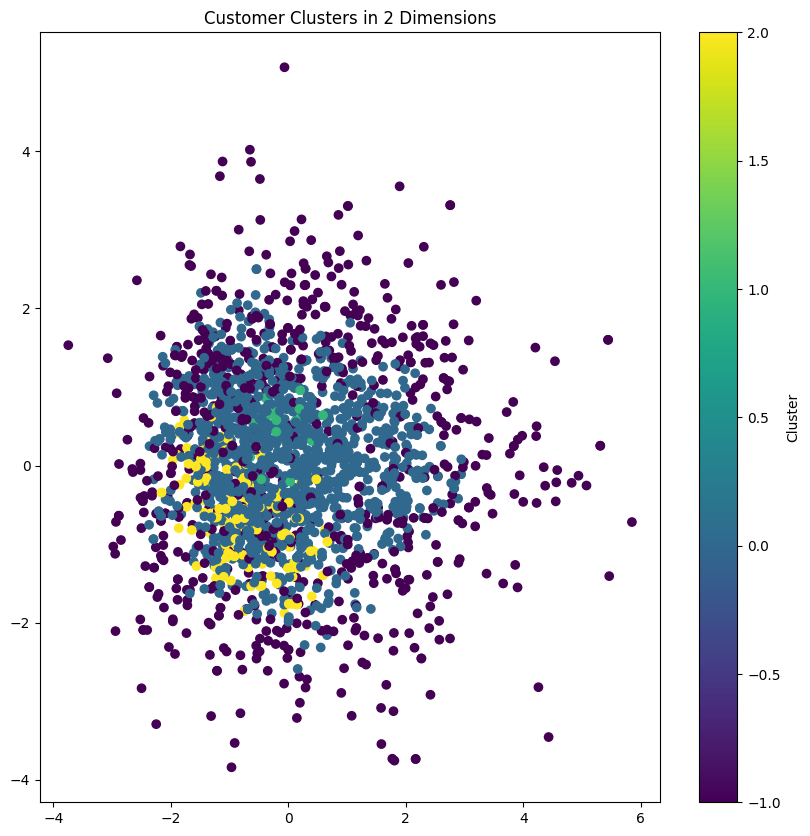

In [130]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], 
           c=clusters)
ax.set_title("Customer Clusters in 3 Dimensions")
ax.legend(['Outliers'])
plt.show()

#plot the 2d dataset
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced.T[1], X_reduced.T[2], c=clusters, cmap='viridis')
plt.title('Customer Clusters in 2 Dimensions')
plt.xlabel('')
plt.ylabel('')
plt.colorbar(label='Cluster')
plt.show()


### About the Cluster

In [131]:
#append the clusters to the original dataset
customer_data['Cluster'] = clusters

#group by cluster and calculate how many responses there were per cluster
cluster_grp = customer_data.groupby('Cluster').Response.agg(['sum', 'count'])
cluster_grp['percent_resp'] = cluster_grp['sum'].values / cluster_grp['count'].values
cluster_grp

sum  count  percent_resp
Cluster                          
-1       176    751      0.234354
 0       118   1291      0.091402
 1         6     29      0.206897
 2        34    169      0.201183

In [132]:
#create new dataframes for each cluster
outlier = customer_data[customer_data.Cluster == -1]
clus0 = customer_data[customer_data.Cluster == 0]
clus1 = customer_data[customer_data.Cluster == 1]
clus2 = customer_data[customer_data.Cluster == 2]

In [133]:
#Create function for plotting distributions per cluster
def create_kdeplot(col, title):
    plt.figure(figsize=(12,8))
    sns.kdeplot(data=outlier, x=col, label='Outliers')
    sns.kdeplot(data=clus0, x=col, label ='Cluster 0')
    sns.kdeplot(data=clus1, x=col, label ='Cluster 1')
    sns.kdeplot(data=clus2, x=col, label ='Cluster 2')
    plt.title(title)
    plt.legend()
    plt.show()
    
#Create function for plotting count of discrete values per cluster
def create_barplot(col, title):
    plt.figure(figsize=(8,8))
    sns.countplot(x=customer_data[col], hue=customer_data["Cluster"])
    plt.title(title)
    plt.legend(['Outliers', 'Cluster 0', 'Cluster 1', 'Cluster 2'])
    plt.show()

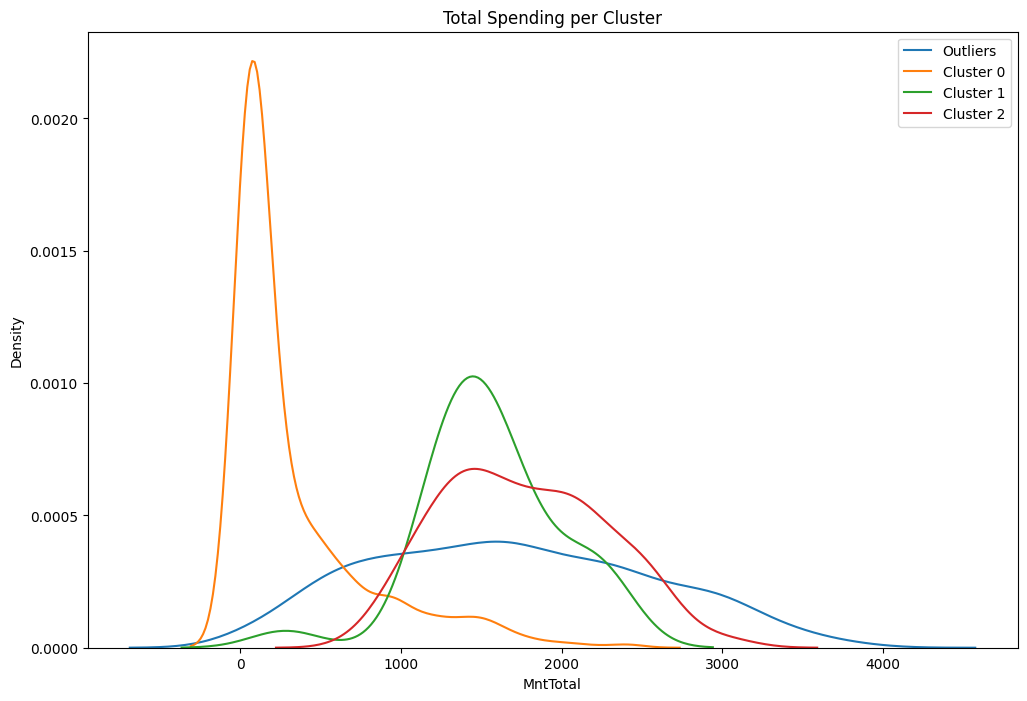

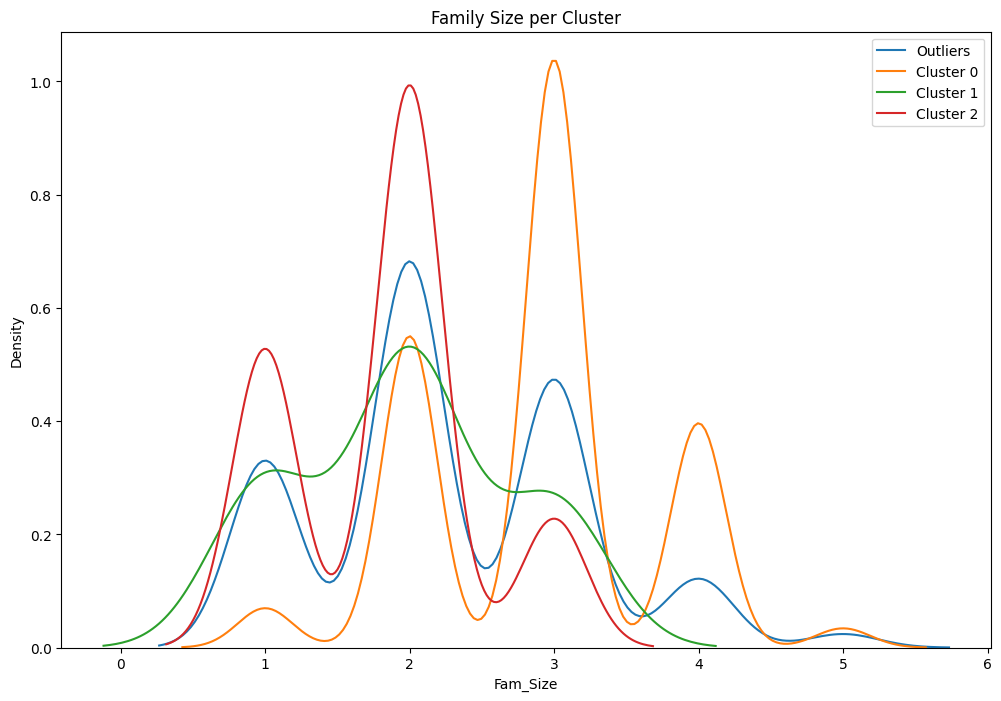

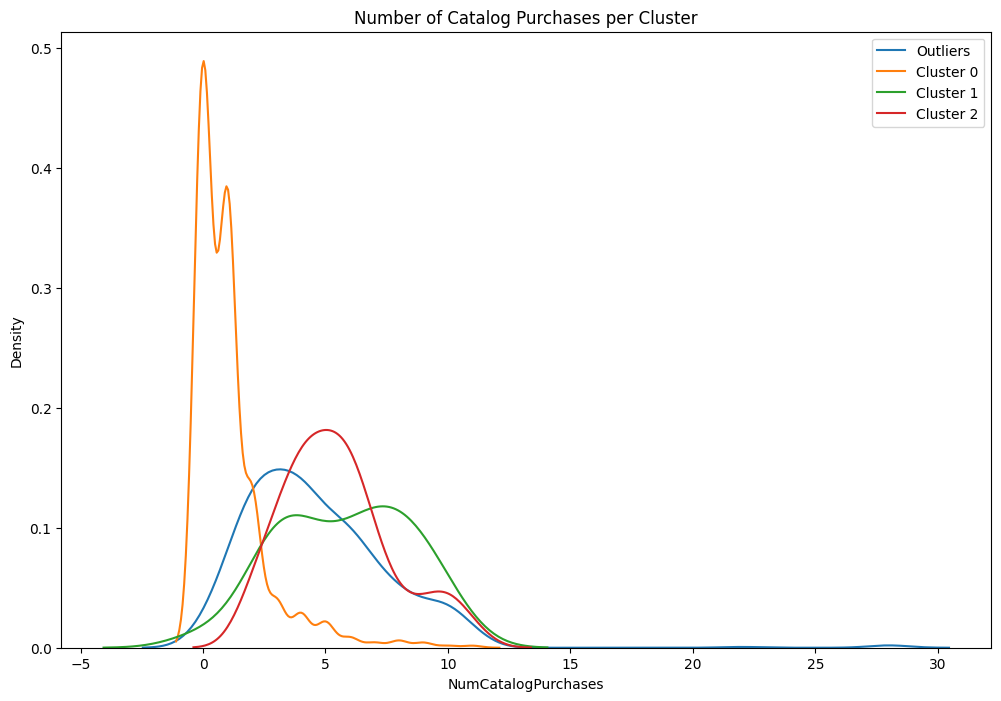

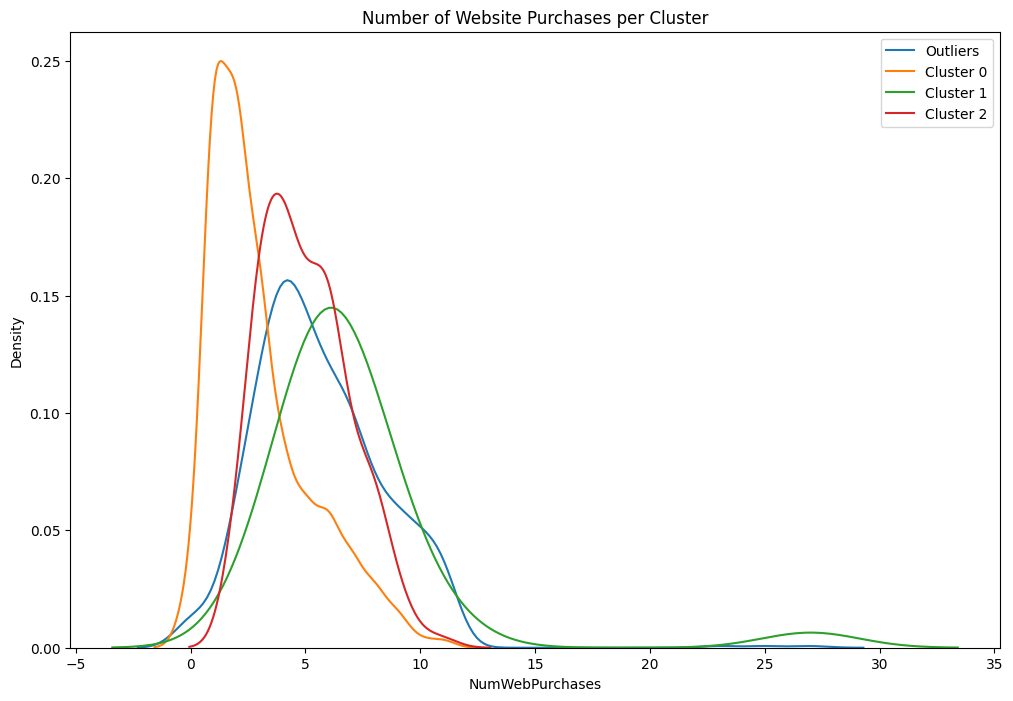

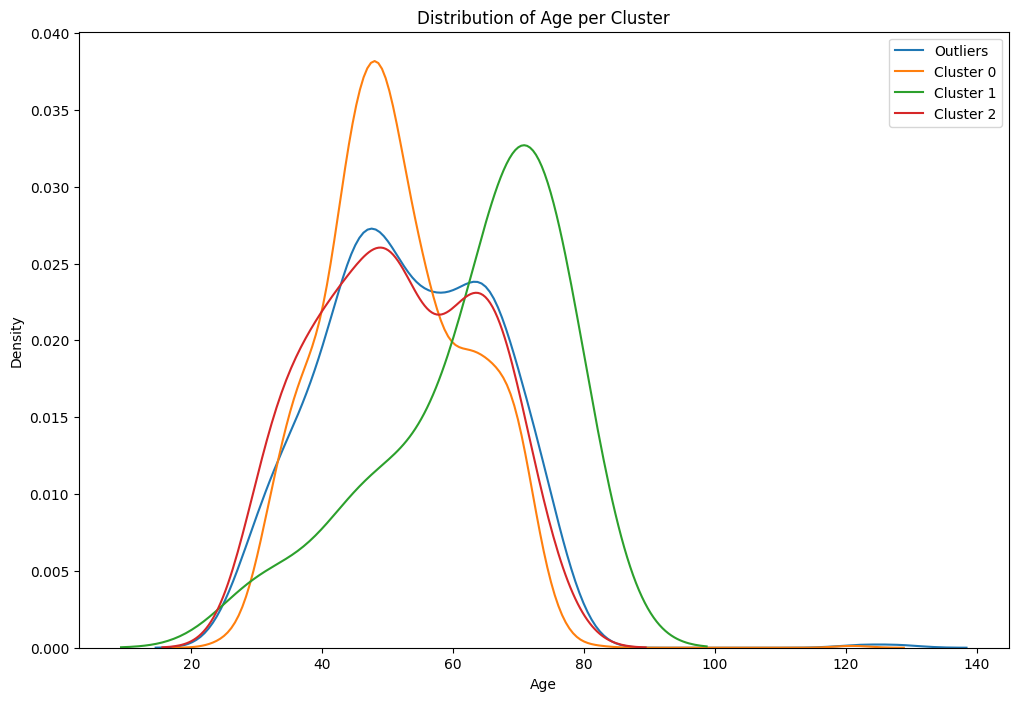

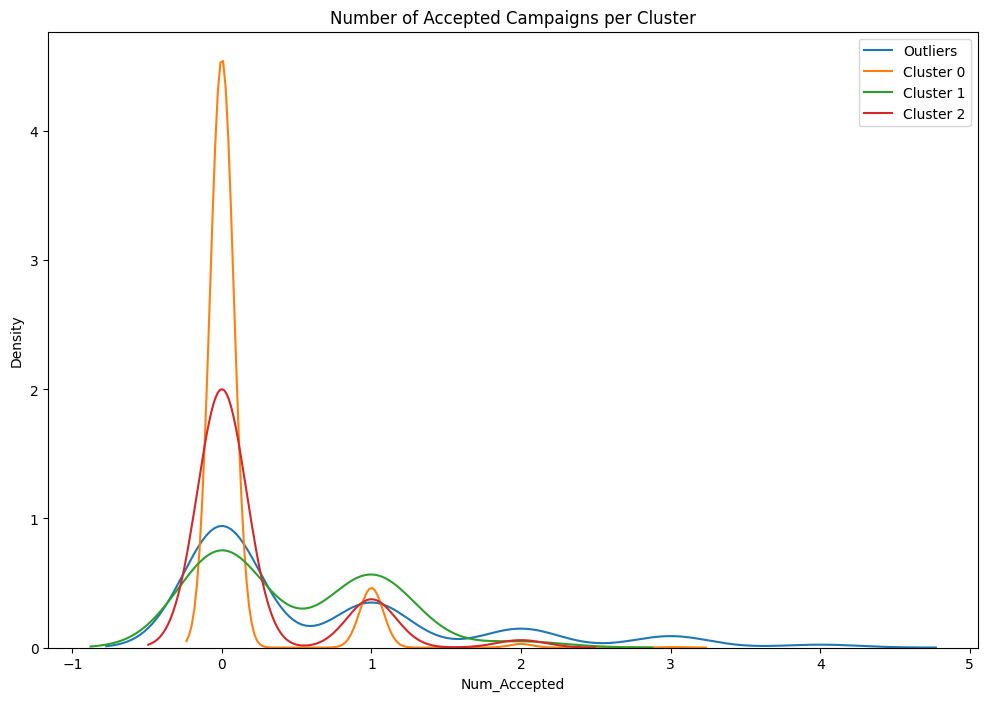

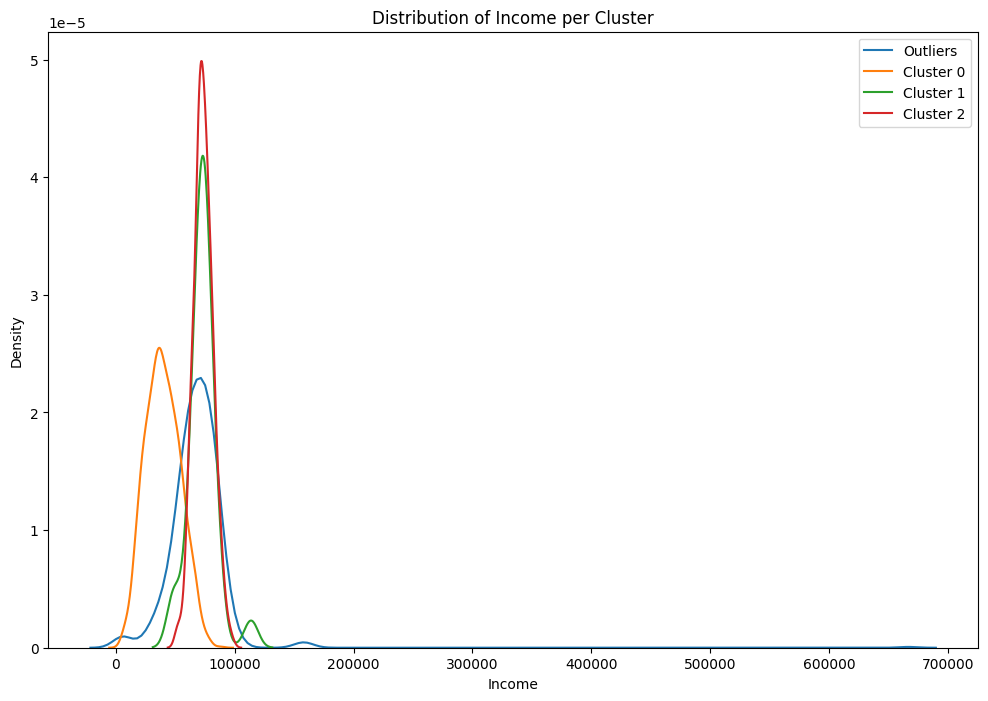

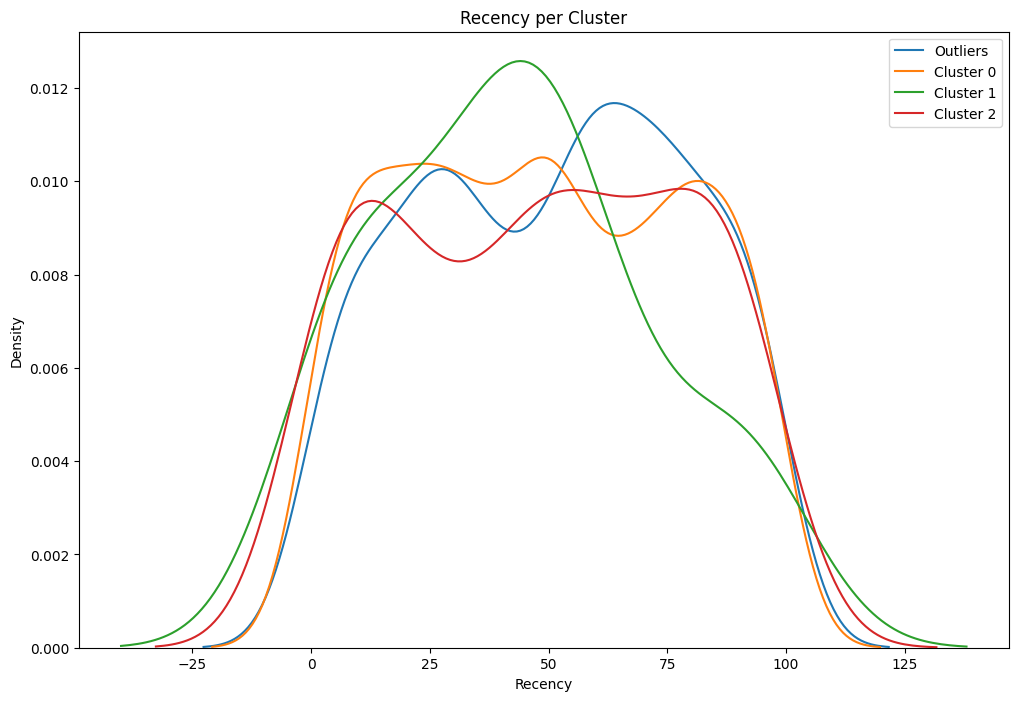

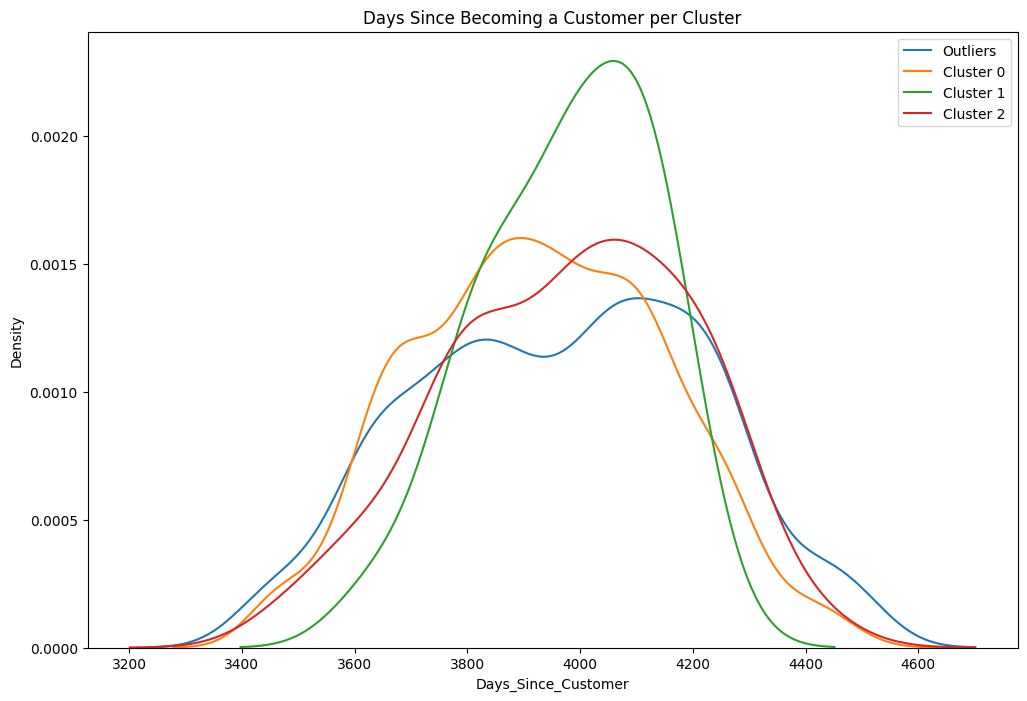

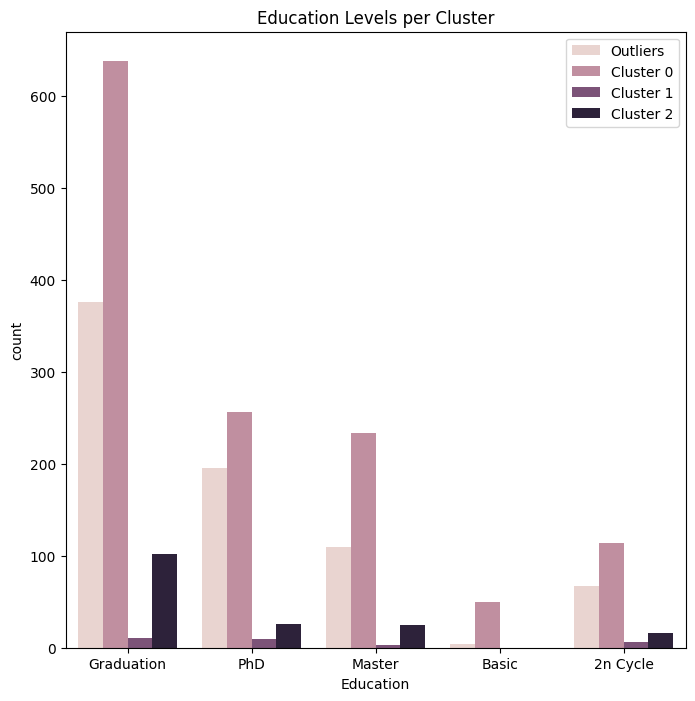

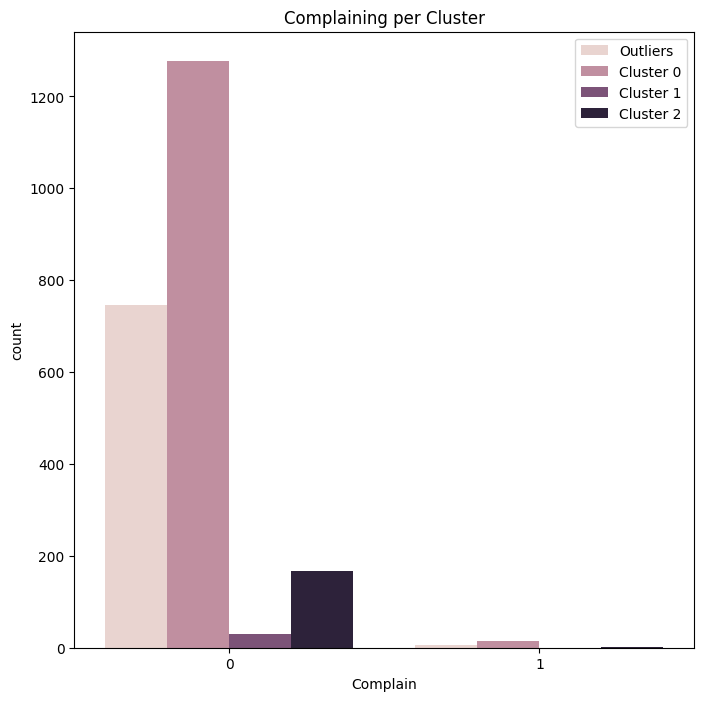

In [134]:
#Create list of variables to plot distributions
vars_to_kdeplot = [('MntTotal', 'Total Spending per Cluster'),
                ('Fam_Size', 'Family Size per Cluster'),
                ('NumCatalogPurchases', 'Number of Catalog Purchases per Cluster'),
                ('NumWebPurchases', 'Number of Website Purchases per Cluster'),
                ('Age', 'Distribution of Age per Cluster'),
                ('Num_Accepted', 'Number of Accepted Campaigns per Cluster'),
                ('Income', 'Distribution of Income per Cluster'),
                  ('Recency', 'Recency per Cluster'),
                  ('Days_Since_Customer', 'Days Since Becoming a Customer per Cluster')]

#Create list of variables to plot in bar graph
vars_to_barplot = [('Education', 'Education Levels per Cluster'),
                  ('Complain', 'Complaining per Cluster')]


#plot all kde plots
for var in vars_to_kdeplot:
    create_kdeplot(var[0], var[1])

#plot all bar plots
for var in vars_to_barplot:
    create_barplot(var[0], var[1])